# Deep SmartGrid

In [1]:
import scipy.io as scpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
from sklearn import tree
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.grid_search import GridSearchCV
from sklearn import svm
from sklearn.manifold import TSNE
import scipy.optimize as opt
import glob
import sys
import os
import theano.tensor as T
from theano import function
from theano import shared
import theano
from theano.tensor.signal import downsample
from theano.tensor.nnet import conv

#np.random.seed(1337)  # for reproducibility
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Layer, Reshape, AutoEncoder, Merge
from keras.layers.convolutional import Convolution2D,MaxPooling2D,Convolution1D,MaxPooling1D,UpSampling2D, ZeroPadding2D
from keras.optimizers import SGD, Adam, RMSprop, Adadelta
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
import keras.utils.visualize_util as vutil
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.regularizers import l1, l2, l1l2, activity_l2, activity_l1
import keras.layers.containers as containers
from keras.layers.noise import GaussianNoise
from keras.regularizers import ActivityRegularizer
from keras import backend as K
import keras.utils.visualize_util as vutil
from keras.models import model_from_json
from keras.utils.visualize_util import plot, to_graph

from IPython.display import SVG

np.set_printoptions(suppress=True)  #Supress exponent of the number 2e-2 == 0.02

%matplotlib inline

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: no CUDA-capable device is detected)
/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
Using Theano backend.


In [2]:
#Ref: http://deeplearning.net/, https://www.kaggle.com/wiki/Tutorials etc..

#caso_I.mat, caso_II.mat, caso_III.mat, caso_base.mat, consumer_data.xlsx

#print(os.getcwd() + "\n")
#print os.listdir(os.getcwd())
dataSmartGrid = scpy.loadmat('demcliMat.mat')
print type(dataSmartGrid)

<type 'dict'>


In [7]:
data = dataSmartGrid['demcliMat']
print data.shape
print data

(12180, 13)
[[ 343.33881535  292.94608369  317.56346931 ...,    0.            0.            2.        ]
 [ 229.55690517  183.19172676    0.         ...,    0.            0.            2.        ]
 [ 106.98249046   79.89465389   60.93378272 ...,   50.91543646
    44.87156581    1.        ]
 ..., 
 [ 232.28249497  135.43054     200.91859872 ...,  187.78214091
   191.41443704    0.        ]
 [ 239.19601078  206.37272444  174.6964434  ...,  297.67230497
   202.62736538    0.        ]
 [ 277.38010202  209.01016123  277.00169283 ...,  146.70298371
   309.63963308    0.        ]]


In [8]:
np.unique(data[:,-1:])

array([ 0.,  1.,  2.])

In [9]:
X = data[:,0:-1]
Y = data[:,-1]

print X.shape, Y.shape

(12180, 12) (12180,)


In [17]:
#print X.shape
Y1 = Y
Y1[Y1==2] = 1
print Y1.shape

(12180,)


In [18]:
np.unique(Y1)

array([ 0.,  1.])

In [19]:
#print data[0:5,:]
#print data[0:5,0:-1]
#print data[0:5,-1]


#print X
#print Y
#Splitting data into train and testing. 70% Training and 30% Testing..
X_train, X_test, y_train, y_test = train_test_split(X, Y1, test_size=0.3, random_state=4)

In [20]:
print X_train.shape, y_train.shape, X_test.shape, y_test.shape
#print numpy.unique(Y_test)

(8526, 12) (8526,) (3654, 12) (3654,)


In [21]:
#Random Forest Classification

randForest = RandomForestClassifier(1)
randForest.fit(X_train,y_train)
Y_randForestPred = randForest.predict(X_test)
print metrics.accuracy_score(y_test, Y_randForestPred)

0.935960591133


In [22]:
target_names = ['class 0', 'class 1']

print(classification_report(y_test, Y_randForestPred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.97      0.96      0.97      3402
    class 1       0.53      0.61      0.57       252

avg / total       0.94      0.94      0.94      3654



In [23]:
#Confusion matrix
conf = metrics.confusion_matrix(y_test,Y_randForestPred)
print conf

[[3267  135]
 [  99  153]]


In [25]:
print metrics.roc_auc_score(y_test, Y_randForestPred)

0.78373015873


In [26]:
#Decision Tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
Y_treePred = clf.predict(X_test)
print metrics.accuracy_score(y_test, Y_treePred)

0.943623426382


In [27]:
target_names = ['class 0', 'class 1']

print(classification_report(y_test, Y_treePred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.97      0.97      0.97      3402
    class 1       0.59      0.61      0.60       252

avg / total       0.94      0.94      0.94      3654



In [28]:
print metrics.roc_auc_score(y_test, Y_treePred)

0.787845385068


In [37]:
batch_size = 200
nb_classes = 2
nb_epoch = 300

# the data, shuffled and split between train and test sets
#(X_train, y_train), (X_test, y_test) = X_train, X_test, Y_train, Y_test

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

model0 = Sequential()
model0.add(Dense(10, input_dim=12))
model0.add(Activation('relu'))
model0.add(Dropout(0.5))

model0.add(Dense(8))
model0.add(Activation('relu'))
model0.add(Dropout(0.5))

model0.add(Dense(6))
model0.add(Activation('relu'))
model0.add(Dropout(0.5))

model0.add(Dense(nb_classes))
model0.add(Activation('sigmoid'))

rms = RMSprop()
model0.compile(loss='binary_crossentropy', optimizer=rms)

hist  = model0.fit(X_train, Y_train,
          batch_size=batch_size, nb_epoch=nb_epoch,
          show_accuracy=True, verbose=2,
          validation_data=(X_test, Y_test))
score = model0.evaluate(X_test, Y_test,
                       show_accuracy=True, verbose=0)

print('Test accuracy:', score[1])
print('Test score:', score[0])

(8526, 'train samples')
(3654, 'test samples')
Train on 8526 samples, validate on 3654 samples
Epoch 1/300
0s - loss: 6.2009 - acc: 0.5289 - val_loss: 7.0821 - val_acc: 0.6546
Epoch 2/300
0s - loss: 4.7870 - acc: 0.6293 - val_loss: 2.0156 - val_acc: 0.9368
Epoch 3/300
0s - loss: 3.6866 - acc: 0.7060 - val_loss: 0.8850 - val_acc: 0.9310
Epoch 4/300
0s - loss: 2.3065 - acc: 0.7912 - val_loss: 0.8241 - val_acc: 0.9310
Epoch 5/300
0s - loss: 1.3551 - acc: 0.8632 - val_loss: 0.7873 - val_acc: 0.9310
Epoch 6/300
0s - loss: 0.7412 - acc: 0.9192 - val_loss: 0.7817 - val_acc: 0.9310
Epoch 7/300
0s - loss: 0.5981 - acc: 0.9319 - val_loss: 0.7137 - val_acc: 0.9305
Epoch 8/300
0s - loss: 0.5527 - acc: 0.9326 - val_loss: 0.6382 - val_acc: 0.9310
Epoch 9/300
0s - loss: 0.5088 - acc: 0.9341 - val_loss: 0.5445 - val_acc: 0.9308
Epoch 10/300
0s - loss: 0.4755 - acc: 0.9329 - val_loss: 0.4590 - val_acc: 0.9313
Epoch 11/300
0s - loss: 0.4517 - acc: 0.9342 - val_loss: 0.3974 - val_acc: 0.9313
Epoch 12/300

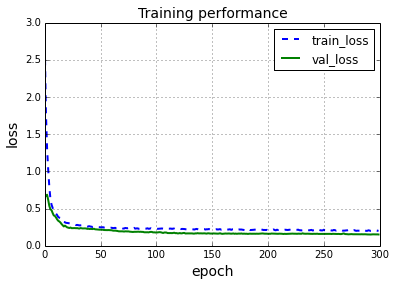

In [121]:
plt.figure()
plt.title('Training performance',fontsize=14)
plt.plot(hist.epoch, hist.history['loss'],'--', label='train_loss', lw=2)
plt.plot(hist.epoch, hist.history['val_loss'], label='val_loss', lw=2)
plt.legend()
plt.xlabel('epoch', fontsize=14)
plt.ylabel('loss', fontsize=14)

plt.grid(True)
plt.savefig('smartgrid_nn_loss.png')

In [92]:
Y_preds_prob = model0.predict_proba(X_test, verbose=0)
print(Y_preds_prob[:5])

[[ 0.94578737  0.05444811]
 [ 0.97044486  0.02951063]
 [ 0.96501523  0.03498937]
 [ 0.9646076   0.03540104]
 [ 0.95387185  0.04625737]]


In [93]:
Y_preds_nn = model0.predict_classes(X_test, verbose=0)
print(Y_preds_nn[:10])

[0 0 0 0 0 0 0 0 0 0]


In [94]:
#Confusion matrix of logistic regression
conf = metrics.confusion_matrix(y_test,Y_preds_nn)
#plt.imshow(conf)
print conf

[[3402    0]
 [ 141  111]]


In [128]:
print 3402/(3402.+141) #sensitivity
print 111/(0+111)      #specificity

print 3402/(3402.+141)

0.960203217612
1
0.960203217612


In [122]:
target_names = ['class 0', 'class 1']

print(classification_report(y_test, Y_preds_nn, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.96      1.00      0.98      3402
    class 1       1.00      0.44      0.61       252

avg / total       0.96      0.96      0.95      3654



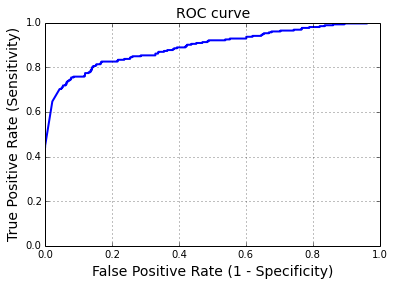

In [124]:
#ROC curve
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test, Y_preds_prob[:,1])
plt.plot(fpr, tpr, lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve',fontsize=14)
plt.xlabel('False Positive Rate (1 - Specificity)',fontsize=14) #fontweight='bold'
plt.ylabel('True Positive Rate (Sensitivity)',fontsize=14)
plt.grid(True)

plt.savefig('smartgrid_nn_roc.png')


In [97]:
print metrics.roc_auc_score(y_test, Y_preds_prob[:,1])

0.891950813247


In [38]:
#Will print layer shape..
def print_layers_shapes(model):
    for l in model.layers:
        print("{} : {} : {}".format(type(l), l.input_shape, l.output_shape))

In [39]:
print X_train.shape, y_train.shape, X_test.shape, y_test.shape

(8526, 12) (8526,) (3654, 12) (3654,)


In [40]:
X_train_1 = X_train.reshape(8526,12,1)
X_test_1 = X_test.reshape(3654,12,1)

print X_train_1.shape, X_test_1.shape 

(8526, 12, 1) (3654, 12, 1)


In [41]:
# 1D conv

# set parameters:
batch_size = 20
input_length = X_train_1.shape[1]
nb_epoch = 200
nb_classes = 2

print('Build model...')

model = Sequential()

model.add(Convolution1D(nb_filter=64,
                        filter_length=3,
                        border_mode='valid',
                        activation='relu',
                        input_dim=1, 
                        input_length=input_length)) 
                       
model.add(Convolution1D(nb_filter=32,
                        filter_length=3,
                        border_mode='valid',
                        activation='relu'))
                        
model.add(MaxPooling1D(pool_length=2))

model.add(Convolution1D(nb_filter=16,
                        filter_length=3,
                        border_mode='valid',
                        activation='relu'))

model.add(Convolution1D(nb_filter=16,
                        filter_length=3,
                        border_mode='same',
                        activation='relu'))

model.add(MaxPooling1D(pool_length=2))

# Adding GRU layer 
#model.add(GRU(output_dim=14))
#model.add(Activation('relu'))

#print_layers_shapes(model)

model.add(Flatten())

model.add(Dense(10))
model.add(Dropout(0.25))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(nb_classes)) 
model.add(Activation('sigmoid'))

#print_layers_shapes(model)

rms = RMSprop()
model.compile(loss='binary_crossentropy', optimizer=rms)



print('Train...')
history = model.fit(X_train_1, Y_train, batch_size=batch_size,
          nb_epoch=nb_epoch, show_accuracy=True,
          validation_data=(X_test_1, Y_test),verbose=2)

score, acc = model.evaluate(X_test_1, Y_test, batch_size=batch_size,
                            show_accuracy=True)

print('Test accuracy:', acc)
print('Test score:', score)


Build model...
Train...
Train on 8526 samples, validate on 3654 samples
Epoch 1/200
1s - loss: 0.2971 - acc: 0.9415 - val_loss: 0.1657 - val_acc: 0.9600
Epoch 2/200
1s - loss: 0.2164 - acc: 0.9592 - val_loss: 0.1705 - val_acc: 0.9666
Epoch 3/200
1s - loss: 0.1934 - acc: 0.9601 - val_loss: 0.1350 - val_acc: 0.9680
Epoch 4/200
1s - loss: 0.1826 - acc: 0.9615 - val_loss: 0.1346 - val_acc: 0.9685
Epoch 5/200
1s - loss: 0.1676 - acc: 0.9628 - val_loss: 0.1246 - val_acc: 0.9685
Epoch 6/200
1s - loss: 0.1607 - acc: 0.9652 - val_loss: 0.1307 - val_acc: 0.9691
Epoch 7/200
1s - loss: 0.1681 - acc: 0.9640 - val_loss: 0.1286 - val_acc: 0.9683
Epoch 8/200
1s - loss: 0.1546 - acc: 0.9639 - val_loss: 0.1180 - val_acc: 0.9699
Epoch 9/200
1s - loss: 0.1518 - acc: 0.9638 - val_loss: 0.1263 - val_acc: 0.9713
Epoch 10/200
1s - loss: 0.1473 - acc: 0.9654 - val_loss: 0.1221 - val_acc: 0.9693
Epoch 11/200
1s - loss: 0.1517 - acc: 0.9653 - val_loss: 0.1179 - val_acc: 0.9699
Epoch 12/200
1s - loss: 0.1556 - ac

In [42]:
#vutil.plot(model, to_file='smartgrid_cnn1d.png')
#vutil.plot(autoencoder, recursive=True, show_shape=True).create(prog='dot', format="png")
#SVG(vutil.to_graph(model, recursive=True, show_shape=True).create(prog='dot', format="svg"))

graph = to_graph(model, show_shape=True)
graph.write_png("smartgrid_cnn1D.png")

True

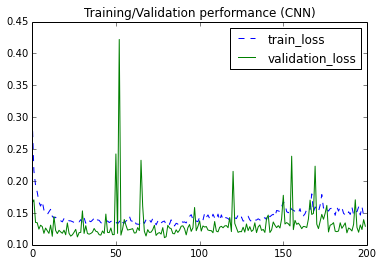

In [43]:
plt.figure()
plt.title('Training/Validation performance (CNN)')
plt.plot(history.epoch, history.history['loss'],'--', label='train_loss')
plt.plot(history.epoch, history.history['val_loss'], label='validation_loss')
plt.legend()

In [144]:
Y_preds_prob_cnn = model.predict_proba(X_test_1, verbose=0)
print(Y_preds_prob_cnn[:5])

[[ 0.92793822  0.071464  ]
 [ 0.987046    0.0131061 ]
 [ 0.96406353  0.03540505]
 [ 0.97863036  0.02137077]
 [ 0.94966322  0.04960407]]


In [145]:
Y_preds_cnn = model.predict_classes(X_test_1, verbose=0)
print(Y_preds_cnn)

[0 0 0 ..., 0 0 0]


In [146]:
np.unique(Y_preds_cnn) #[-550:]

array([0, 1])

In [147]:
np.unique(y_test)

array([ 0.,  1.])

In [148]:
print np.sum(Y_preds_cnn==1)
print 3386+89

151
3475


In [149]:
#Confusion matrix of logistic regression
conf = metrics.confusion_matrix(y_test,Y_preds_cnn)
#plt.imshow(conf)
print conf

[[3402    0]
 [ 101  151]]


In [150]:
target_names = ['class 0', 'class 1']

print(classification_report(y_test, Y_preds_cnn, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.97      1.00      0.99      3402
    class 1       1.00      0.60      0.75       252

avg / total       0.97      0.97      0.97      3654



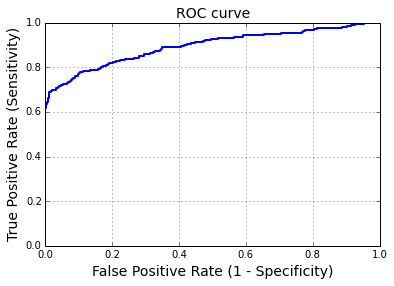

In [153]:
#ROC curve
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr1, tpr1, thresholds = metrics.roc_curve(y_test, Y_preds_prob_cnn[:,1])
plt.plot(fpr1, tpr1, lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve',fontsize=14)
plt.xlabel('False Positive Rate (1 - Specificity)',fontsize=14) #fontweight='bold'
plt.ylabel('True Positive Rate (Sensitivity)',fontsize=14)
plt.grid(True)

plt.savefig('smartgrid_cnn1d_roc.png')

#Y_logPred_prob = logReg.predict_proba(X_test)[:, 1]

In [154]:
print metrics.roc_auc_score(y_test, Y_preds_prob_cnn[:,1])

0.893839291547


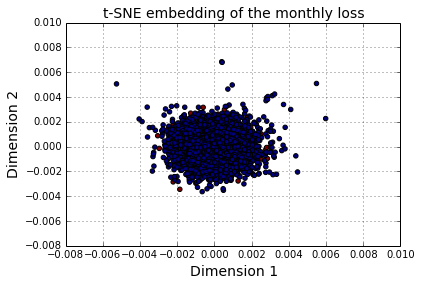

In [16]:
X_tsne = TSNE(learning_rate=100).fit_transform(X)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y1)

plt.title('t-SNE embedding of the monthly loss',fontsize=14)
plt.xlabel('Dimension 1',fontsize=14)
plt.ylabel('Dimension 2',fontsize=14)
plt.grid(True)
plt.savefig('tsne_smartgrid.png')

In [51]:
#print X.shape, Y1.shape

# Matlab scripts for reading the data(cell-array) and saving it into mat file..

In [ ]:
# %load mapPC2DemcliCol.m

%Function mapping from Demcli Column to pc column.
function pc_col = mapPC2DemcliCol(demcliCol)
   
   pc_col = 0;  
   if(demcliCol == 1)
      pc_col = 1;
   end
   if(demcliCol == 3)
      pc_col = 2;
   end
   if(demcliCol == 5)
      pc_col = 3;
   end   
end


In [ ]:
# %load smartgrid.m

clear all;

%files--> caso_I.mat, caso_II.mat, caso_III.mat, caso_base.mat
%addpath ../data

load data/caso_I.mat; %ccarga, demcli, pc

nRows = size(demcli,1); %85
nCols = size(demcli,2); %6

isEmptyCell = cellfun(@isempty, demcli);%returns 0,1 matrix(85 by 6)

[nCellRows, nCellCols] = cellfun(@size, demcli); %shape of individual cell
totalRows = sum(cellfun(@length, demcli)(:)); %Total rows of cells
totalCols = unique(nCellCols)(2);  %column of cell

demcliMat =  []; %zeros(totalRows,totalCols); %Holder of the cell data.
pc_col = 1;
%iterate all the cell
for i=1:nRows  %85
  for j = 1:2:nCols %since 1,3,5 only contains data   
    pc_col = mapPC2DemcliCol(j);  
    %fprintf('%i\n %i\n %i\n', i,j,pc_col);
    if(!isEmptyCell(i,j))        
        demcliMat = [demcliMat; demcli{i,j}, pc{i,pc_col}];
    end       
  end
end

%saves the file into demcliMat.mat in version 7. After version 7 file stored in hdf5
%It can be open using h5py package in python.

%save demcliMat.mat demcliMat -v7


